# *Nov 24 monthly Demo - Runge*

This notebook contains all of the code used to produce the results and figures included in the paper

### Load dependencies

In [ ]:
import os
import json
import sympy
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Callable

# MIRA modeling dependencies
from mira.metamodel import *
from mira.metamodel.ops import stratify
from mira.examples.concepts import susceptible, exposed, infected, recovered
from mira.modeling import Model
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.sources.amr.petrinet import template_model_from_amr_json
from mira.metamodel.io import model_to_json_file, model_from_json_file

# PyCIEMSS dependencies
import 

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories
from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

In [3]:
scenario_3_total_popp =100000 # US Census Bureau
initial_vacc = 0
initial_hosp = 0
initial_recovered = 0
initial_exposed = 0
initial_deaths = 0
initial_infected = 100
initial_susceptible = 99900
initial_ccases = 0
initial_chosp = 0

# Model derivation and initialization

### Define units

In [4]:
person_units = lambda: Unit(expression=sympy.Symbol('person'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

### Define model concepts

In [5]:
c = {
    'S': Concept(name='S', units=person_units()),  # Susceptible
    'E': Concept(name='E', units=person_units()),  # Exposed
    'V': Concept(name="V", units=person_units()),  # Vaccinated
    'I': Concept(name='I', units=person_units()),  # Infectious
    'R': Concept(name='R', units=person_units()),  # Recovered
    'H': Concept(name="H", units=person_units()),  # Hospitalized
    'D': Concept(name="D", units=person_units()),  # Deceased
    'C_c': Concept(name="C_c", units=person_units()),  # Cumulative Cases
    'C_h': Concept(name="C_h", units=person_units())  # Cumulative Hospitalizations
}

for concept in c:
    c[concept].name = concept


### Define model parameters with uncertainty

Death rates among hospitalized https://www.cdc.gov/nchs/covid19/nhcs/hospital-mortality-by-week.htm

In [6]:

parameters = {
    'beta': Parameter(name='beta', value=sympy.Float(0.6), units=per_day_units()),  # Transmission rate
    'N': Parameter(name='total_population', value=sympy.Float(scenario_3_total_popp), units=person_units()),  
    'nu': Parameter(name='nu', value=sympy.Float(0.005), units=per_day_units()),  # Vaccination rate
    'sigma': Parameter(name='sigma', value=sympy.Float(0.10), units=per_day_units()),  # Rate exposed and unvaccinated individuals become infected
    'epsilon': Parameter(name='epsilon', value=sympy.Float(0.05), units=per_day_units()),  # Rate exposed and vaccinated individuals become infected
    'delta': Parameter(name='delta', value=sympy.Float(0.05), units=per_day_units()),  # Rate infected individuals recover
    'gamma': Parameter(name='gamma', value=sympy.Float(0.02), units=per_day_units()),  # Rate infected individuals become hospitalized
    'alpha': Parameter(name='alpha', value=sympy.Float(0.01), units=per_day_units()),  # Death rate for infected individuals who are not hospitalized
    'rho': Parameter(name='rho', value=sympy.Float(0.10), units=per_day_units()),  # Rate hospitalized individuals recover
    'mu': Parameter(name='mu', value=sympy.Float(0.02), units=per_day_units()),  # Death rate for hospitalized individuals
}

parameters_q1 = parameters.copy()
parameters_q1['epsilon'] = Parameter(name='epsilon', value=sympy.Float(0.05), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .5*0.05,
                                                            'maximum': 1.5*0.05}))
parameters_q1['gamma'] = Parameter(name='gamma', value=sympy.Float(0.02), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .5*0.02,
                                                            'maximum': 1.5*0.02}))


### Define `SymPy` variables

In [7]:
S, E, I, R, H, V, D,  C_c, C_h, beta, N, nu, sigma, epsilon, delta, gamma, alpha, rho, mu = sympy.symbols('S E I R H V D C_c C_h beta N nu sigma epsilon delta gamma alpha rho mu')

### Set initial conditions

In [8]:

initials = {
    "S": Initial(concept=c["S"], expression=initial_susceptible),
    "E": Initial(concept=c["E"], expression=initial_exposed),
    "I": Initial(concept=c["I"], expression=initial_infected),
    "R": Initial(concept=c["R"], expression=initial_recovered),
    'H': Initial(concept=c["H"], expression=initial_hosp),
    'V': Initial(concept=c["V"], expression=initial_vacc),
    'D': Initial(concept=c["D"], expression=initial_deaths),
    'C_c': Initial(concept=c["C_c"], expression=initial_ccases),
    'C_h': Initial(concept=c["C_h"], expression=initial_chosp),
}

### Define templates

In [9]:
##### S -> E beta #
se = ControlledConversion(
    subject=c['S'],
    outcome=c['E'],
    controller=c['I'],
    rate_law=beta*S*I / N
)


##### V - E # even though the diagram doesn't have V -> E, the equation does include V*I/N to calculate Exposed
ve = ControlledConversion(
    subject=c['V'],
    outcome=c['E'],
    controller=c['I'],
    rate_law=epsilon*V*I / N
)


# S -> V
rv = NaturalConversion(
    subject=c['S'],
    outcome=c['V'],
    rate_law=nu*S
)

#### E -> I
ei = NaturalConversion(
    subject=c['E'],
    outcome=c['I'],
    rate_law=sigma*E
)


#### I -> R
ir = NaturalConversion(
    subject=c['I'],
    outcome=c['R'],
    rate_law=delta*I # not r_IR*(1 - r_IH)*I
)


#### I -> H
ih = NaturalConversion(
    subject=c['I'],
    outcome=c['H'],
    rate_law=gamma*I # not r_IR*r_IH*I as in previous model
)

#### I -> D
id = NaturalConversion(
    subject=c['I'],
    outcome=c['D'],
    rate_law=alpha*I
)

#### H -> R
hr = NaturalConversion(
    subject=c['H'],
    outcome=c['R'],
    rate_law=rho*H
)


#### H -> D
hd = NaturalConversion(
    subject=c['H'],
    outcome=c['D'],
    rate_law=mu*H
)


### Cumulative compartments
# Cumulative Cases
### Cumulative compartments
# Cumulative Cases
ccases = ControlledProduction(
    controller=c['E'],
    outcome=c['C_c'],
    rate_law=sigma*E
)

# Cumulative Hospitalizations
chosp = ControlledProduction(
    controller=c['I'],
    outcome=c['C_h'],
    rate_law=gamma*I # instead of r_IR*r_IH*I as orignal due to being a different model (i guess)
)

# List of all transitions
transitions = [se, ve, rv, ei, ir, ih, id, hr, hd, ccases, chosp]




### Define observables

In [10]:
observables_seir = {
    'cases': Observable(name='cases', expression=I),
    'hospitalized': Observable(name='hospitalized', expression=H),
    'deceased': Observable(name='deceased', expression=D),
    'c_cases': Observable(name='c_cases', expression=C_c),
    'c_hosp': Observable(name='c_hosp', expression=C_h),
}

### Define template model and save as petrinet AMR

In [11]:
model1 = "scenerio_3_mo.json"
num_iterations = 100
num_samples = 100
start_time = 0.0
end_time = 200.0
logging_step_size = 1.0

solution_mapping = [lambda x : x]

seir_model = TemplateModel(
    templates=transitions,
    parameters=parameters_q1,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables_seir,
    annotations=Annotations(name='SEVIRHD model')
)

# Save as JSON
with open(model1, 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)

# Sample from model prior

### Set model path and parameters for sampling

### 4.1 Sensitivity Analysis

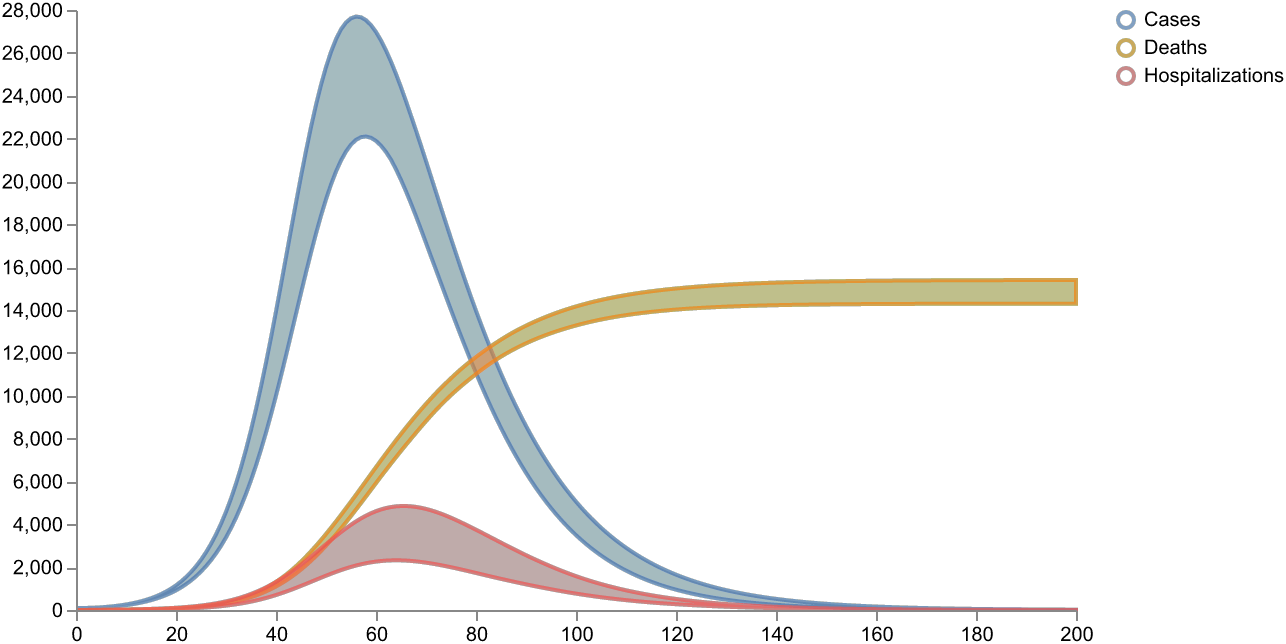

In [32]:
result_sensitivity = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
# display(result1['data'].head())

# Plot results for all states
nice_labels = {
        "cases_observable_state": "Cases",
        "hospitalized_observable_state": "Hospitalizations", 
        "deceased_observable_state": "Deaths"
        }


schema = plots.trajectories(
    result_sensitivity["data"], 
    keep=["cases_observable_state", "hospitalized_observable_state", "deceased_observable_state"],
    relabel=nice_labels
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

In [33]:
result_sensitivity['data']

,timepoint_id,sample_id,timepoint_unknown,persistent_epsilon_param,persistent_gamma_param,persistent_N_param,persistent_beta_param,persistent_nu_param,persistent_sigma_param,persistent_delta_param,...,R_state,H_state,D_state,C_c_state,C_h_state,cases_observable_state,hospitalized_observable_state,deceased_observable_state,c_cases_observable_state,c_hosp_observable_state
0,0,0,0.0,0.067822,0.014021,100000.0,0.6,0.005,0.1,0.05,...,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000
1,1,0,1.0,0.067822,0.014021,100000.0,0.6,0.005,0.1,0.05,...,4.932525,1.285369,0.986505,2.837960,1.364641,95.633568,1.285369,0.986505,2.837960,1.364641
2,2,0,2.0,0.067822,0.014021,100000.0,0.6,0.005,0.1,0.05,...,9.903037,2.404564,1.980608,10.857610,2.706440,96.569420,2.404564,1.980608,10.857610,2.706440
3,3,0,3.0,0.067822,0.014021,100000.0,0.6,0.005,0.1,0.05,...,15.141991,3.440412,3.028398,23.589642,4.093469,101.978874,3.440412,3.028398,23.589642,4.093469
4,4,0,4.0,0.067822,0.014021,100000.0,0.6,0.005,0.1,0.05,...,20.854761,4.457856,4.170952,40.861641,5.584710,111.378098,4.457856,4.170952,40.861641,5.584710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20095,196,99,196.0,0.033881,0.021096,100000.0,0.6,0.005,0.1,0.05,...,72411.546875,2.927490,14482.310547,86804.226562,22605.208984,7.456407,2.927490,14482.310547,86804.226562,22605.208984
20096,197,99,197.0,0.033881,0.021096,100000.0,0.6,0.005,0.1,0.05,...,72412.226562,2.739758,14482.441406,86804.335938,22605.359375,6.976075,2.739758,14482.441406,86804.335938,22605.359375
20097,198,99,198.0,0.033881,0.021096,100000.0,0.6,0.005,0.1,0.05,...,72413.000000,2.564025,14482.567383,86804.445312,22605.500000,6.526649,2.564025,14482.567383,86804.445312,22605.500000
20098,199,99,199.0,0.033881,0.021096,100000.0,0.6,0.005,0.1,0.05,...,72413.351562,2.399523,14482.674805,86804.523438,22605.636719,6.106110,2.399523,14482.674805,86804.523438,22605.636719


In [13]:
# import seaborn as sns

# result1["data"][result1["data"]["timepoint_id"] == 10]
# result1["data"].columns
# param_columns = [col for col in result1["data"].columns if col.endswith('_param')]
# min_max_values = {col: (result1["data"][col].min(), result1["data"][col].max()) for col in param_columns}
# print(min_max_values)
# plt.figure(figsize=(12, 6))
# # Create a heatmap for persistent_beta_param and persistent_mu_param
# heatmap_data = result1["data"][['persistent_beta_param', 'persistent_mu_param', 'cases_observable_state']]
# heatmap_data

# heatmap_data_avg = heatmap_data.groupby(['persistent_beta_param', 'persistent_mu_param']).mean().reset_index()
# heatmap_data_pivot = heatmap_data_avg.pivot("persistent_beta_param", "persistent_mu_param", "cases_observable_state")
# print(heatmap_data_pivot)
# sns.heatmap(heatmap_data_pivot, cmap="YlGnBu", annot=False)
# plt.title("Heatmap of Cases Observable State")
# plt.show()


[24571.6796875  18698.30859375 23904.06054688 23530.0234375
 20338.59179688 20463.53515625 22182.16015625 21893.734375
 25389.08398438 22751.44140625 23040.828125   24098.44726562
 24616.52734375 22709.15039062 26017.64257812 19665.21679688
 24959.3046875  20223.203125   20290.68359375 23793.21875
 25576.95703125 23460.38671875 22016.14648438 22089.75390625
 23142.0390625  24535.953125   20803.75       19386.87109375
 21620.47460938 24788.4765625  20229.90820312 21125.38867188
 19695.6640625  20262.11914062 25555.67773438 24868.453125
 20550.88085938 22295.45703125 23326.66210938 24713.625
 22602.61523438 22619.08203125 21944.90429688 24026.296875
 24060.453125   19687.45898438 19634.25       24234.39257812
 21983.23828125 18802.15234375 21297.29101562 24108.08398438
 20679.82226562 23409.61328125 18880.45507812 19651.9296875
 19920.89453125 21520.80273438 21964.96484375 21545.48046875
 19795.26953125 20142.046875   19012.625      19368.44140625
 19264.33984375 24533.76757812 25325.312

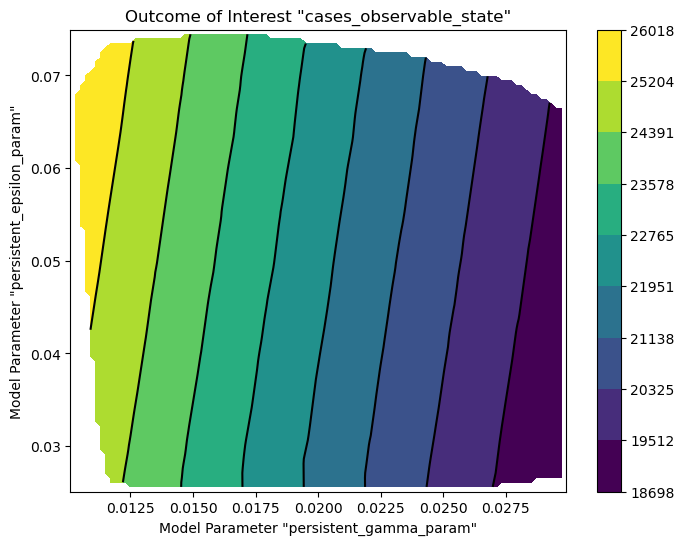

In [55]:
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt

d1 = result_sensitivity["data"]
\
def get_contour_plot(d1, x, column_x, column_y, outcome):

    n = d1["sample_id"].max()
    b = np.array([d1[(d1["sample_id"] == i) & (d1["timepoint_id"] == x)][column_x].iloc[0] for i in range(n)])
    rHR = np.array([d1[(d1["sample_id"] == i) & (d1["timepoint_id"] == x)][column_y].iloc[0] for i in range(n)])
    outcomes = np.array([d1[(d1["sample_id"] == i) & (d1["timepoint_id"] == x)][outcome].iloc[0] for i in range(n)])
    print(outcomes)

    xy = np.c_[b, rHR]
    lut2 = LinearNDInterpolator(xy, outcomes)

    # Interpolate to a uniform grid
    m = 100
    x = np.linspace(b.min(), b.max(), m)
    y = np.linspace(rHR.min(), rHR.max(), m)
    xx, yy = np.meshgrid(x, y)

    zz = lut2(xx, yy)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    h1 = ax.contourf(xx, yy, zz, np.linspace(outcomes.min(), outcomes.max(), 10), cmap=plt.cm.viridis.resampled(10 - 1))
    h2 = ax.contour(xx, yy, zz, h1.levels, colors='k')
    __ = fig.colorbar(h1, ax=ax)

    __ = plt.setp(ax, xlabel=f'Model Parameter "{column_x}"', ylabel=f'Model Parameter "{column_y}"', title=f'Outcome of Interest "{outcome}"')

get_contour_plot(d1, 50, "persistent_gamma_param", "persistent_epsilon_param", "cases_observable_state")


### 4.2 Decision Maker


In [15]:
# 𝛼 (alpha) r_ID  = 0.01 / 𝑑𝑎𝑦 is the death rate for infected individuals who are not hospitalized
# 𝛽 (beta) r_SE= 0.60 new infections per infected person/day is the transmission rate
# 𝛿 (delta) r_IR= 0.05 / 𝑑𝑎𝑦 is the rate infected individuals recover
# 𝜖 (epsilon) r_VE (I think the diagram in pdf is wrong V goes to E, not I based on the equations)= 0.05 / 𝑑𝑎𝑦 is the rate exposed and vaccinated individuals become infected
# 𝛾 (gamma) r_IH = 0.02 / 𝑑𝑎𝑦 is the rate infected individuals become hospitalized
# 𝜇 (mu) r_HD = 0.02 / 𝑑𝑎𝑦 is the death rate for hospitalized individuals
# 𝜈 (nu) r_SV = 0.005 / 𝑑𝑎𝑦 is the vaccination rate
# 𝜌 (rho) r_HR = 0.10 / 𝑑𝑎𝑦 is the rate hospitalized individuals recover
# 𝜎 (sigma) r_EI = 0.10 / 𝑑𝑎𝑦 is the rate exposed and unvaccinated individuals become infected

In [ ]:
model_intervention = "scenerio_3_mo_intervention.json"
start_time = 0.0
end_time = 200.0

seir_model = TemplateModel(
    templates=transitions,
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables_seir,
    annotations=Annotations(name='SEVIRHD model')
)

# Save as JSON
with open(model_intervention, 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)


   timepoint_id  sample_id  \
0             0          0   
1             1          0   
2             2          0   
3             3          0   
4             4          0   

   cases_observable_state_intervention_beta_085_nu_001  \
0                                         100.000000     
1                                          95.294052     
2                                          95.124092     
3                                          98.719246     
4                                         105.577560     

   hospitalized_observable_state_intervention_beta_085_nu_001  \
0                                           0.000000            
1                                           1.205322            
2                                           2.245637            
3                                           3.190661            
4                                           4.094460            

   deceased_observable_state_intervention_beta_085_nu_001  \
0                 

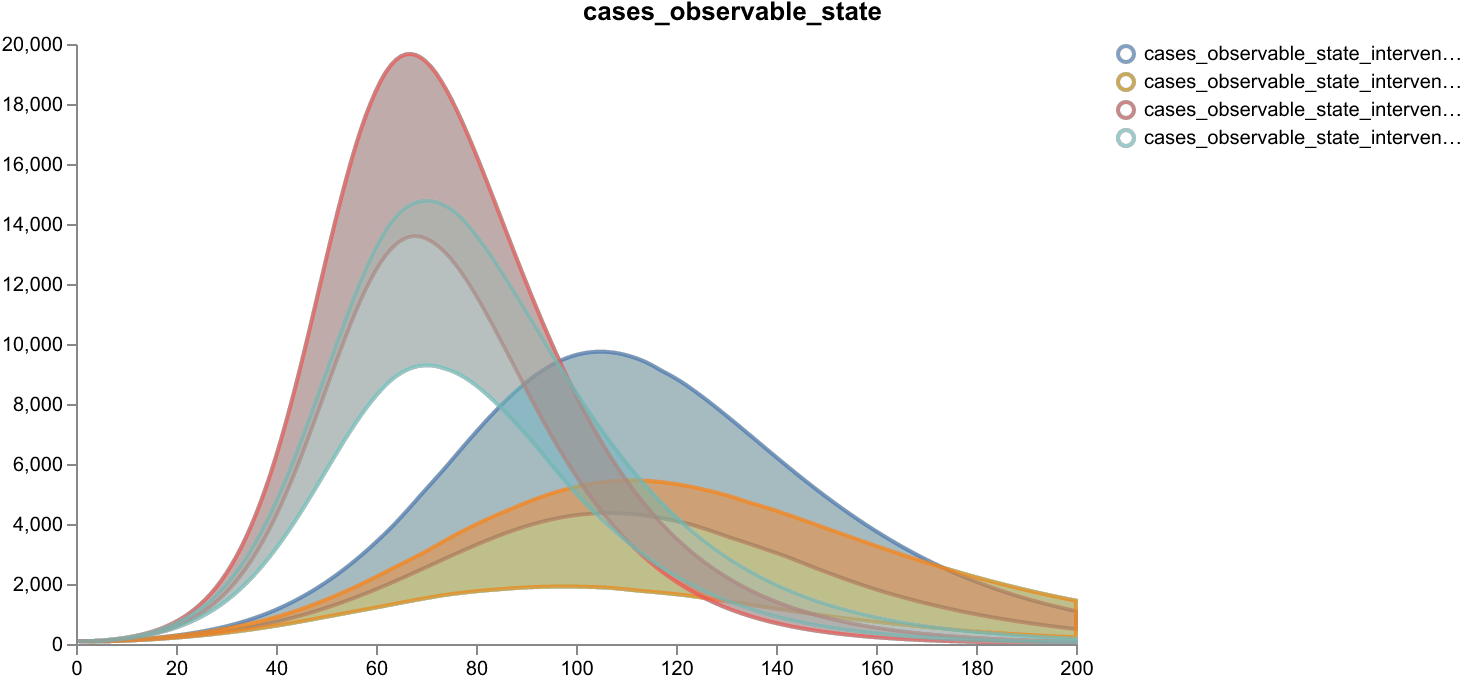

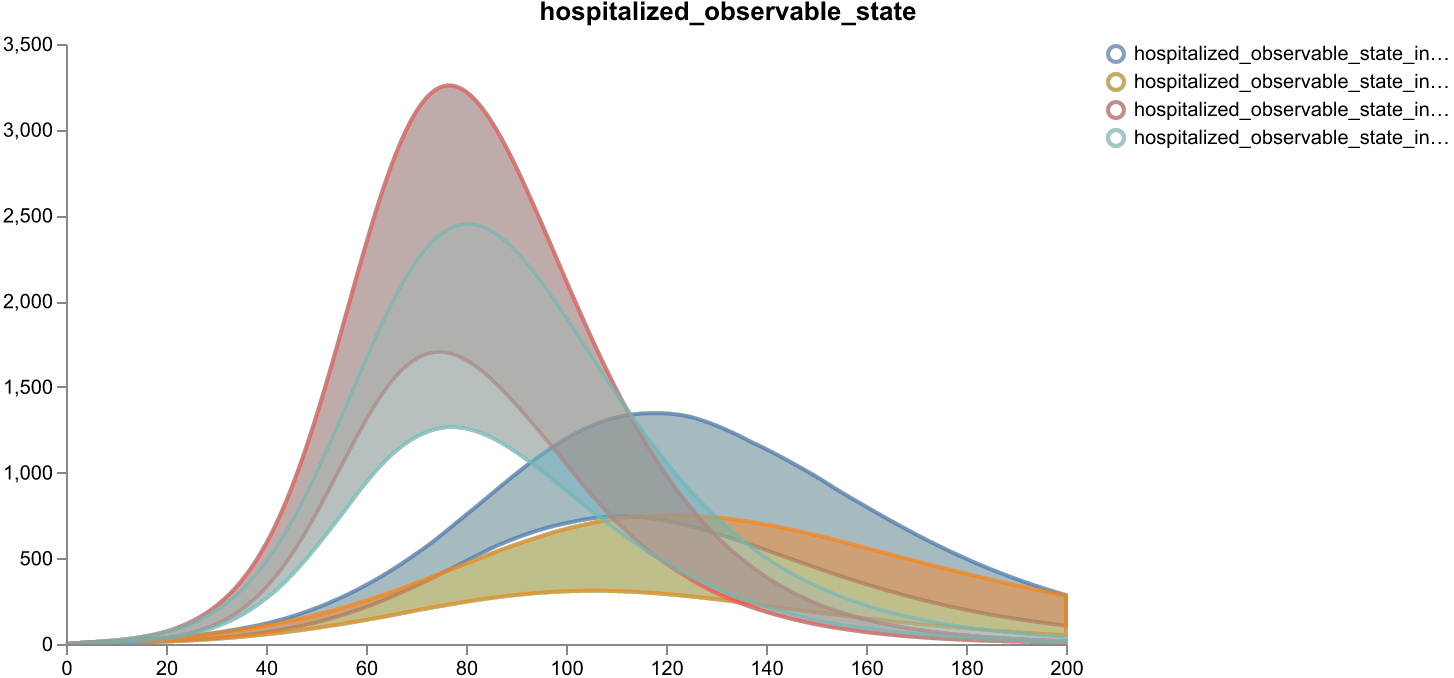

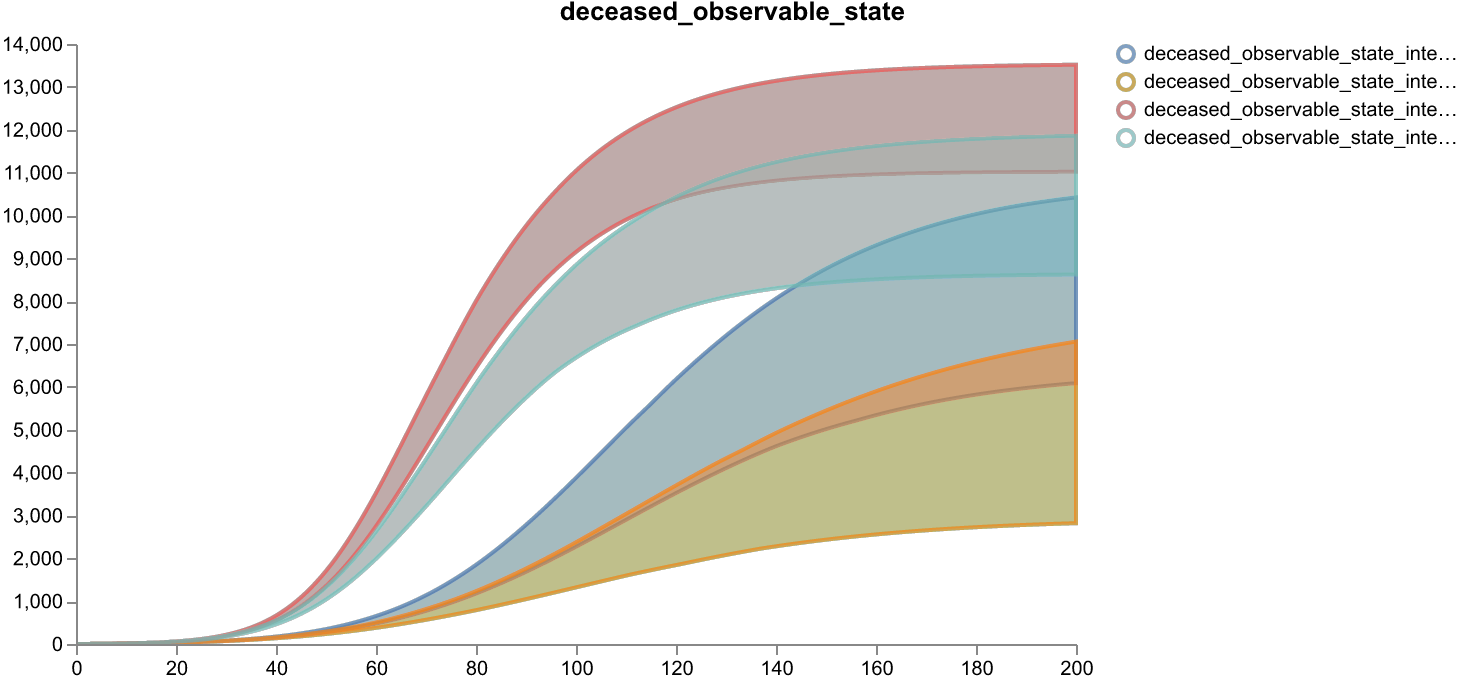

{'intervention_beta_085_nu_001': {'cases': array([52.42879486, 50.16283798, 40.7988205 , 48.35619354, 71.37865448,
         50.5658226 , 47.69022369, 53.31289673, 40.74133301, 46.61086655,
         54.91775513, 58.84851456, 46.07013321, 38.90339279, 69.38383484,
         50.6267662 , 87.34257507, 62.46348953, 47.05817795, 45.56914902,
         24.02381706, 17.79867744, 73.99026489, 60.1386528 , 34.61372375,
         41.25871277, 27.57294464, 84.00495148, 77.6257019 , 46.96449661,
         36.91447449, 47.64353561, 18.34101105, 48.50018692, 47.41248322,
         54.74094772, 44.80801773, 48.55275345, 63.79888153, 52.01623535,
         37.2419014 , 49.03522491, 72.83769989, 81.27307892, 39.88119125,
         50.29993439, 40.81404114, 25.52172661, 33.84479904, 33.2281456 ,
         38.39837646, 76.58060455, 29.50571251, 26.81652641, 51.79717636,
         52.22507095, 33.21748734, 45.63574219, 42.51302719, 43.24335098,
         30.54433823, 67.48152161, 22.10395622, 59.71136856, 29.3834781

In [ ]:
interventions = {
    "beta_085_nu_001": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.85), "nu": torch.tensor(0.01)}},
    "beta_050_nu_001": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.5), "nu": torch.tensor(0.01)}},
    "beta_085_nu_015": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.85), "nu": torch.tensor(0.015)}},
    "beta_050_nu_015": {torch.tensor(0): {"beta": lambda x : x * torch.tensor(0.5), "nu": torch.tensor(0.015)}}
}
results_dict = {}
nice_labels = {
    "cases_observable_state": "Cases",
    "hospitalized_observable_state": "Hospitalizations", 
    "deceased_observable_state": "Deaths"
}
all_results = pd.DataFrame()
for key, intervention in interventions.items():
    invervention_sample_results = pyciemss.sample(model_intervention, end_time, logging_step_size, num_samples, 
                                                start_time=start_time, 
                                                static_parameter_interventions=intervention)
    # Add timepoint_id and sample_id to all_results
    all_results["timepoint_id"] = invervention_sample_results["data"]["timepoint_id"]
    all_results["sample_id"] = invervention_sample_results["data"]["sample_id"]
    for key2 in nice_labels:
        if key2 in invervention_sample_results["data"].columns:
            all_results[f"{key2}_intervention_{key}"] = invervention_sample_results["data"][key2]

    # Get results at timepoint_id 200 for each observable state
    final_results = invervention_sample_results["data"][invervention_sample_results["data"]["timepoint_id"] == 200]
    intervention_results = {
        "cases": final_results["cases_observable_state"].values,
        "hospitalized": final_results["hospitalized_observable_state"].values,
        "deceased": final_results["deceased_observable_state"].values
    }
    results_dict[f"intervention_{key}"] = intervention_results



# Display separately for each observable state
for state in ["cases_observable_state", "hospitalized_observable_state", "deceased_observable_state"]:
    schema = plots.trajectories(
        all_results,
        keep=[col for col in all_results.columns if state in col],
        relabel=nice_labels,
        title=f"{state}"
    )
    plots.save_schema(schema, f"_schema_intervention_state.json")
    display(plots.ipy_display(schema, dpi=150))
results_dict

In [ ]:

results_dict
#

{'intervention_beta_085_nu_001': {'cases': array([52.42879486, 50.16283798, 40.7988205 , 48.35619354, 71.37865448,
         50.5658226 , 47.69022369, 53.31289673, 40.74133301, 46.61086655,
         54.91775513, 58.84851456, 46.07013321, 38.90339279, 69.38383484,
         50.6267662 , 87.34257507, 62.46348953, 47.05817795, 45.56914902,
         24.02381706, 17.79867744, 73.99026489, 60.1386528 , 34.61372375,
         41.25871277, 27.57294464, 84.00495148, 77.6257019 , 46.96449661,
         36.91447449, 47.64353561, 18.34101105, 48.50018692, 47.41248322,
         54.74094772, 44.80801773, 48.55275345, 63.79888153, 52.01623535,
         37.2419014 , 49.03522491, 72.83769989, 81.27307892, 39.88119125,
         50.29993439, 40.81404114, 25.52172661, 33.84479904, 33.2281456 ,
         38.39837646, 76.58060455, 29.50571251, 26.81652641, 51.79717636,
         52.22507095, 33.21748734, 45.63574219, 42.51302719, 43.24335098,
         30.54433823, 67.48152161, 22.10395622, 59.71136856, 29.3834781

### 4.3 Decision Maker + Uncertainity at 50 days



In [19]:
model_intervention = "scenerio_3_mo_intervention_uncertainity.json"
start_time = 0.0
end_time = 50.0
interventions = [
    static_parameter_interventions_opt_1,
    static_parameter_interventions_opt_2,
    static_parameter_interventions_opt_3,
    static_parameter_interventions_opt_4
]
seir_model = TemplateModel(
    templates=transitions,
    parameters=parameters_q1,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables_seir,
    annotations=Annotations(name='SEVIRHD model')
)

# Save as JSON
with open(model_intervention, 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)


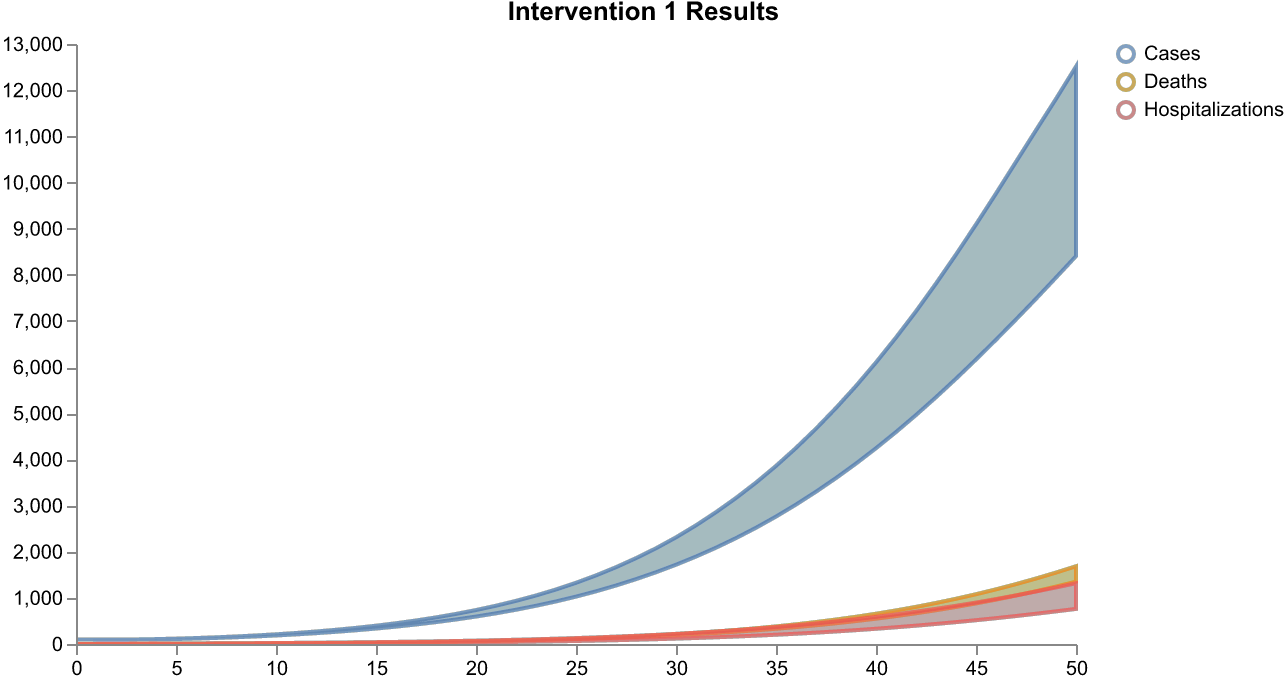

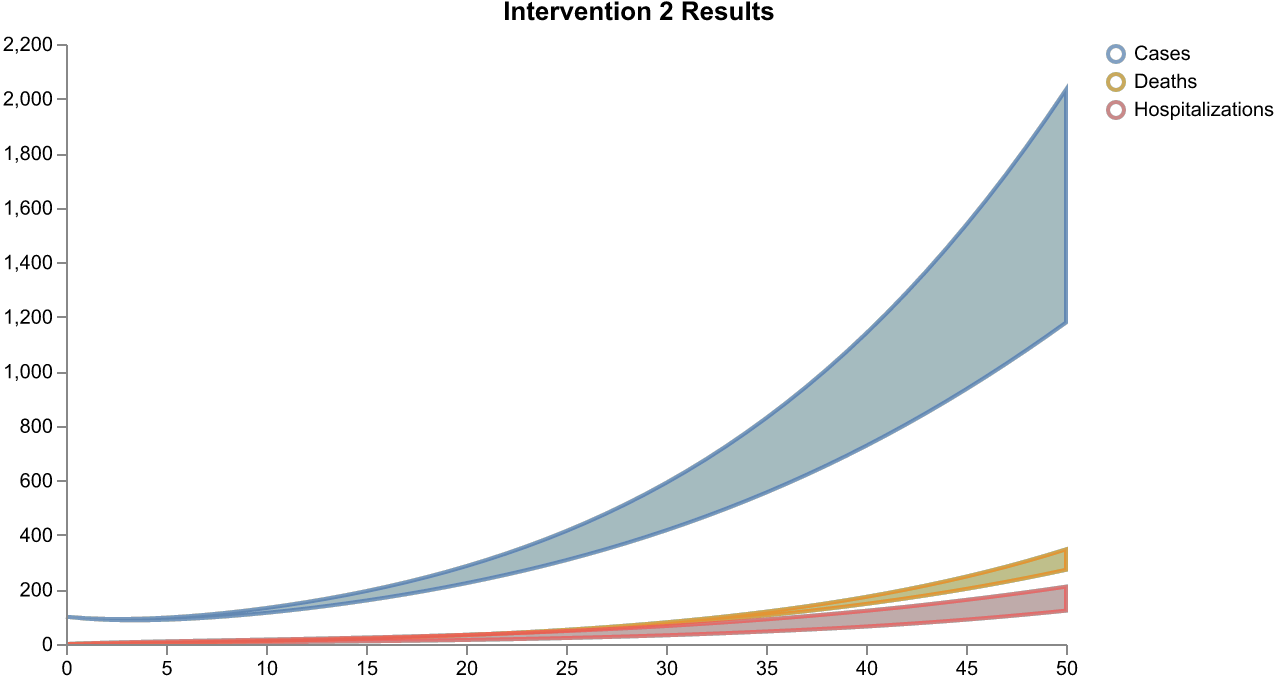

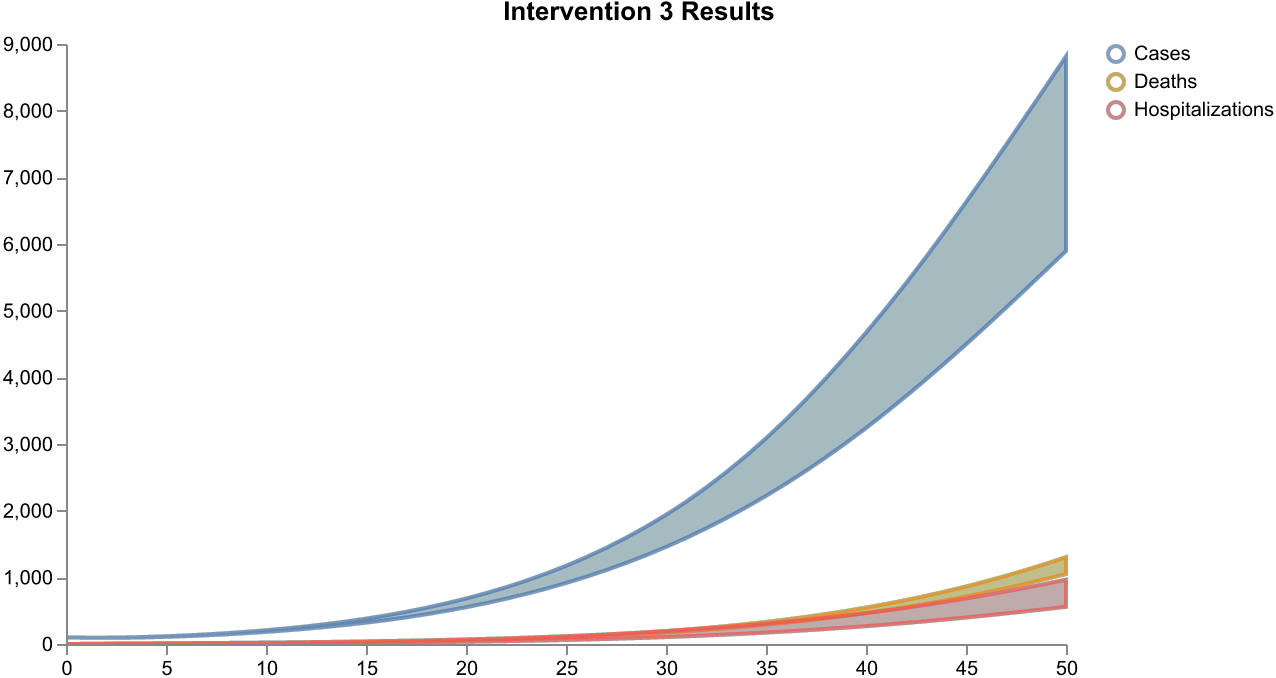

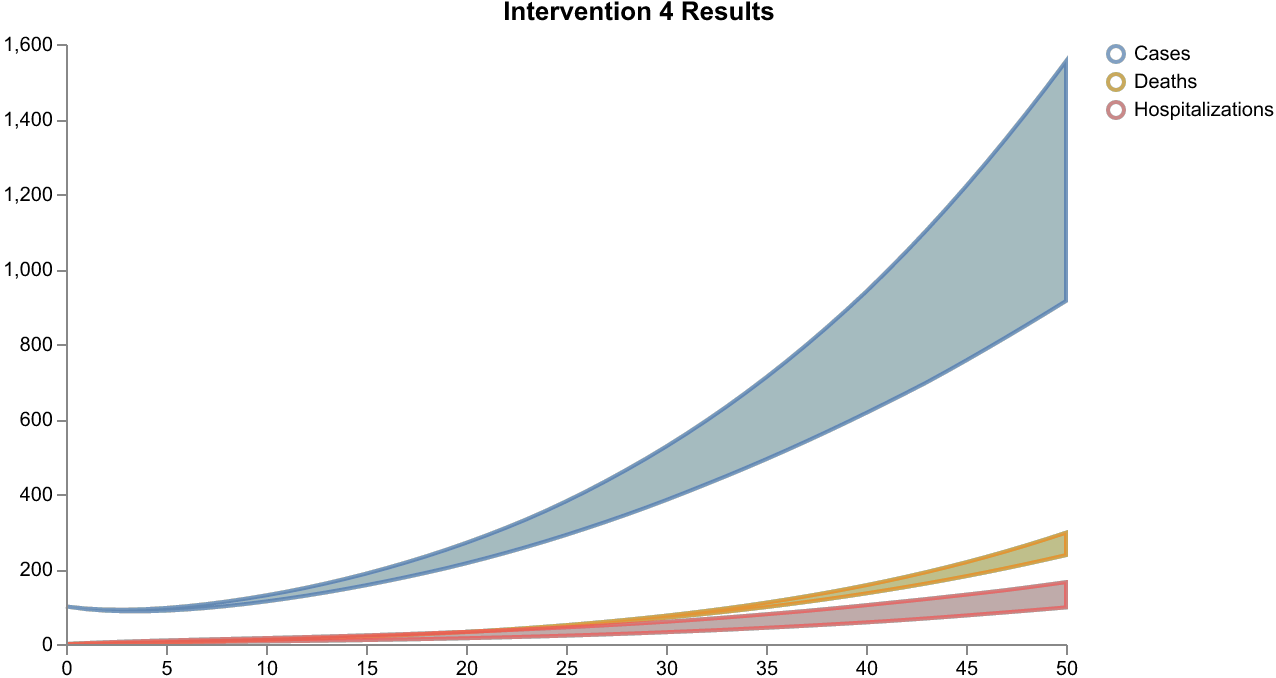

In [20]:

for i, intervention in enumerate(interventions):
    invervention_sample_results = pyciemss.sample(model_intervention, end_time, logging_step_size, num_samples, 
                                                start_time=start_time, 
                                                static_parameter_interventions=intervention)

    # Plot results for all states
    nice_labels = {
        "cases_observable_state": "Cases",
        "hospitalized_observable_state": "Hospitalizations", 
        "deceased_observable_state": "Deaths"
    }

    schema = plots.trajectories(
        invervention_sample_results["data"], 
        keep=["cases_observable_state", "hospitalized_observable_state", "deceased_observable_state"],
        relabel=nice_labels,
        title=f"Intervention {i+1} Results"
    )
    plots.save_schema(schema, f"_schema_intervention_{i+1}.json")
    display(plots.ipy_display(schema, dpi=150))

### 4.4 Horizon Scanning Maker


In [21]:
scenario_3_total_popp_seid =800000 # US Census Bureau

initial_exposed = 0
initial_deaths = 0
initial_infected = 100
initial_susceptible = 79900
initial_ccases = 0


In [22]:
c_seid = {
    'S': Concept(name='S', units=person_units()),  # Susceptible
    'E': Concept(name='E', units=person_units()),  # Exposed
    'I': Concept(name='I', units=person_units()),  # Infectious
    'D': Concept(name='D', units=person_units()),  # Recovered
    'C_c': Concept(name="C_c", units=person_units())  # Cumulative Cases
}

for concept in c_seid:
    c_seid[concept].name = concept


In [23]:
parameters_seid = {
    'beta': Parameter(name='beta', value=sympy.Float(0.5), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .2,
                                                            'maximum': .8})),  # Transmission rate
    'N': Parameter(name='total_population', value=sympy.Float(scenario_3_total_popp_seid), units=person_units()),  
    'sigma': Parameter(name='sigma', value=sympy.Float(0.15), units=per_day_units()),  # Rate exposed and unvaccinated individuals become infected
    'mu': Parameter(name='mu', value=sympy.Float(0.075), units=per_day_units(), distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': .05,
                                                            'maximum': .1})),  # Death rate for hospitalized individuals
}


In [24]:

initials_seid = {
    "S": Initial(concept=c_seid["S"], expression=initial_susceptible),
    "E": Initial(concept=c_seid["E"], expression=initial_exposed),
    "I": Initial(concept=c_seid["I"], expression=initial_infected),
    "D": Initial(concept=c_seid["D"], expression=initial_deaths),
    "C_c": Initial(concept=c_seid["C_c"], expression=initial_ccases),
}


In [25]:
##### S -> E beta #
se = ControlledConversion(
    subject=c['S'],
    outcome=c['E'],
    controller=c['I'],
    rate_law=beta*S*I / N
)


#### E -> I
ei = NaturalConversion(
    subject=c['E'],
    outcome=c['I'],
    rate_law=sigma*E
)




#### I -> D
id = NaturalConversion(
    subject=c['I'],
    outcome=c['D'],
    rate_law=mu*I
)



### Cumulative compartments
# Cumulative Cases
### Cumulative compartments
# Cumulative Cases
ccases = ControlledProduction(
    controller=c['E'],
    outcome=c['C_c'],
    rate_law=sigma*E
)


# List of all transitions
transitions_seid = [se, ei, id, ccases]



In [26]:
observables_seid = {
    'cases': Observable(name='cases', expression=I),
    'deceased': Observable(name='deceased', expression=D),
    'c_cases': Observable(name='c_cases', expression=C_c)
}

In [27]:
model_seid = "scenerio_3_mo_seid.json"
num_iterations = 100
num_samples = 100
start_time = 0.0
end_time = 200.0
logging_step_size = 1.0

solution_mapping = [lambda x : x]

seir_model = TemplateModel(
    templates=transitions_seid,
    parameters=parameters_seid,
    initials=initials_seid,
    time=Time(name='t', units=day_units()),
    observables=observables_seid,
    annotations=Annotations(name='SEID model')
)

# Save as JSON
with open(model_seid, 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)

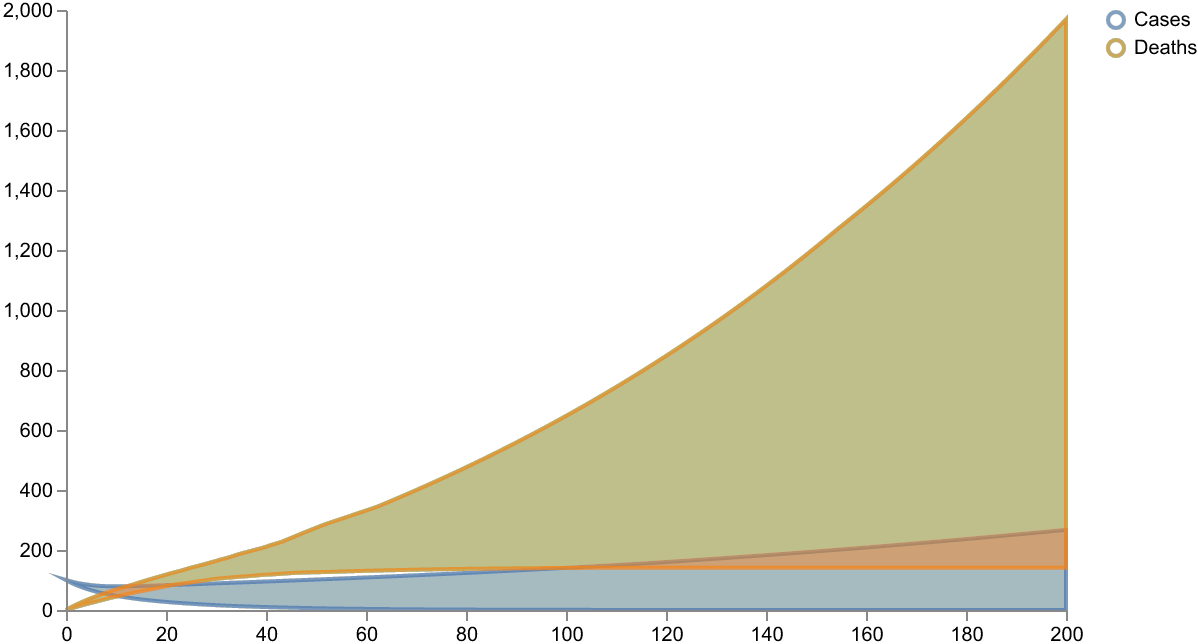

In [28]:
result1 = pyciemss.sample(model_seid, end_time, logging_step_size, num_samples, start_time=start_time)
# display(result1['data'].head())

# Plot results for all states
nice_labels = {
        "cases_observable_state": "Cases",
        "deceased_observable_state": "Deaths"
        }


schema = plots.trajectories(
    result1["data"], 
    keep=["cases_observable_state", "deceased_observable_state"],
    relabel=nice_labels
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)